# Neural Network

This is the core of our project. For running this, you need to have created three accordingly formatted splits of the data by running these files from the repository:
* preprocessing.sh
* splitting_data.py

You don't need to run the following files because this Notebook accesses them directly:
* data_loading.py
* tokenizer.py
* embeddings.py

## Imports

In [49]:
import datasets
import transformers
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
import numpy as np
from tokenizer import tokenize_and_encode, encode_pos
from embeddings import embedding_model

## Data
Please insert the names of the three splits below:

In [205]:
training_file = "middle_train.tsv"
validation_file = "middle_val.tsv"
test_file = "middle_test.tsv"

## Loading the data

In [206]:
data_files = {
            "train": training_file,
            "test": test_file,
            "validation": validation_file
        }

data_sets = datasets.load_dataset("data_loading.py", data_files=data_files)

Using custom data configuration default-0715ccd4c03216d1
Reusing dataset sample (C:\Users\Luisa\.cache\huggingface\datasets\sample\default-0715ccd4c03216d1\0.0.0\cd100589429990ebe2c7713d0ebc54a510b4404ae27f91b9fd14d9da132fa4be)


## Tokenizing the data

In [207]:
# tokens
tokenized_train = tokenize_and_encode("train", data_sets)
tokenized_test = tokenize_and_encode("test", data_sets)
tokenized_validation = tokenize_and_encode("validation", data_sets)
# lists of dictionaries with keys: "input_ids", "token_type_ids", "attention_mask"

# pos-tags
pos_encoded_train = encode_pos("train", data_sets)
pos_encoded_test = encode_pos("test", data_sets)
pos_encoded_validation = encode_pos("validation", data_sets)

print(tokenized_train[0]) # first sentence, tokenized
print(tokenized_train[0]["input_ids"].shape)
print(pos_encoded_train[0]) # first sentence, pos, tokenized
print(pos_encoded_train[0]["input_ids"].shape)

{'input_ids': tensor([[  101,   138,  7721,  1590,  2492,   170,  1490,  2730,  1107,  1134,
          1131,   182,  6334,  2316,  1123,  1711,  1105,  7252,  1103,  7703,
          1104,  1117, 21870,   119,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 0, 0, 0, 0, 0

## Embeddings
!Attention: This might take a while!

In [ ]:
embedded_train = list()
embedded_val = list()
embedded_test = list()
for sentence in tokenized_train:
    embedding = embedding_model(sentence["input_ids"])
    embedded_train.append(embedding["last_hidden_state"])
# shape of embedded sentence = [1,73,768]
for sentence in tokenized_validation:
    embedding = embedding_model(sentence["input_ids"])
    embedded_val.append(embedding["last_hidden_state"])
for sentence in tokenized_test:
    embedding = embedding_model(sentence["input_ids"])
    embedded_test.append(embedding["last_hidden_state"])

## Defining Hyperparameters

In [197]:
# changeable
num_layers = 2
hidden_size = 128 # try 128
learning_rate = 0.00001
batch_size = 64
num_epochs = 20

# fixed
input_size = 768
sequence_length = 73
num_classes = 103

## Setting Seeds

In [198]:
SEED = 1

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Network architecture
For the architecture of the network, we decided to go for an LSTM because it work well for sequence processing while at the same time handling vanishing and exploding gradients better than a regular RNN.<br>

In [199]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0,c0))
        out = self.fc(out.view(sequence_length, -1))
        out = F.log_softmax(out, dim=1)
        return out

## Model instantiation

In [200]:
model = LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5)

## Training loop

In [201]:
def train(epoch_acc, epoch_loss, eval_loss_batch):
    for batch_idx, sentence in enumerate(tokenized_train):
        target = pos_encoded_train[batch_idx]["input_ids"]
        target = target[0]
        
        # do embeddings
        #embedded = embedding_model(sentence["input_ids"])
        #input_sentence = embedded["last_hidden_state"]
        input_sentence = embedded_train[batch_idx]
        
        # feed into model
        scores = model(input_sentence)
        _, predicted = torch.max(scores, 1)
    
        # loss
        loss = criterion(scores, target)
        eval_loss_batch.append(loss.item())
        epoch_loss += loss.item()
        
        # accuracy
        right = 0
        for n, tag in enumerate(predicted):
            if tag == target[n]:
                right += 1
        acc = right / len(predicted)
        epoch_acc += acc
        
        # print info
        #print("batch loss:", loss.item(), "\tbatch accuracy:", acc)
        
        # backpropagate
        loss.backward()
        optimizer.step()
        
    return epoch_acc, epoch_loss, eval_loss_batch

## Testing

In [202]:
def test(epoch_acc, epoch_loss):
    for batch_idx, sentence in enumerate(tokenized_validation):
        target = pos_encoded_train[batch_idx]["input_ids"]
        target = target[0]
        
        # do embeddings
        #embedded = embedding_model(sentence["input_ids"])
        #input_sentence = embedded["last_hidden_state"]
        input_sentence = embedded_val[batch_idx]
        
        # feed into model
        scores = model(input_sentence)
        _, predicted = torch.max(scores, 1)
        
        # loss
        loss = criterion(scores, target)
        epoch_loss += loss.item()
        
        # accuracy
        right = 0
        for n, tag in enumerate(predicted):
            if tag == target[n]:
                right += 1
        acc = right / len(predicted)
        epoch_acc += acc  
        
    return epoch_acc, epoch_loss

## Run Training and Validation

In [203]:
train_eval_loss_epoch = list()
train_eval_loss_batch = list()
val_eval_loss_epoch = list()
for epoch in range(1, num_epochs+1):
    print("--------- EPOCH", epoch, "---------")
    train_epoch_acc = 0
    train_epoch_loss = 0
    val_epoch_acc = 0
    val_epoch_loss = 0
    
    # train
    train_epoch_acc, train_epoch_loss, train_eval_loss_batch = train(train_epoch_acc, train_epoch_loss, train_eval_loss_batch)
    train_epoch_loss = train_epoch_loss/len(tokenized_train)
    train_epoch_acc = train_epoch_acc/len(tokenized_train)
    train_eval_loss_epoch.append(train_epoch_loss)
    
    # validation
    val_epoch_acc, val_epoch_loss = test(val_epoch_acc, val_epoch_loss)
    val_epoch_loss = val_epoch_loss/len(tokenized_validation)
    val_epoch_acc = val_epoch_acc/len(tokenized_validation)
    val_eval_loss_epoch.append(val_epoch_loss)
    
    print("----- Epoch", epoch, "training loss:", train_epoch_loss, "training accuracy:", train_epoch_acc, "-----")
    print("----- Epoch", epoch, "validation loss:", val_epoch_loss, "validation accuracy:", val_epoch_acc, "-----")

--------- EPOCH 1 ---------
----- Epoch 1 training loss: 4.511900506121047 training accuracy: 0.4654619644418538 -----
----- Epoch 1 validation loss: 4.43102283867038 validation accuracy: 0.5482247693597987 -----
--------- EPOCH 2 ---------
----- Epoch 2 training loss: 4.116719414579108 training accuracy: 0.714296123579132 -----
----- Epoch 2 validation loss: 4.003234663788153 validation accuracy: 0.6536203522504892 -----
--------- EPOCH 3 ---------
----- Epoch 3 training loss: 3.42996347584623 training accuracy: 0.7192509472457015 -----
----- Epoch 3 validation loss: 3.401612778099216 validation accuracy: 0.6592116298574224 -----
--------- EPOCH 4 ---------
----- Epoch 4 training loss: 2.6635901788447764 training accuracy: 0.7193966773535418 -----
----- Epoch 4 validation loss: 2.8289028868383292 validation accuracy: 0.659491193737769 -----
--------- EPOCH 5 ---------
----- Epoch 5 training loss: 2.05380121602657 training accuracy: 0.7193238122996217 -----
----- Epoch 5 validation los

----- Epoch 39 training loss: 0.8554300039689592 training accuracy: 0.7578694258233759 -----
----- Epoch 39 validation loss: 1.9819819629192352 validation accuracy: 0.5812133072407043 -----
--------- EPOCH 40 ---------
----- Epoch 40 training loss: 0.8501133697622634 training accuracy: 0.7585980763625774 -----
----- Epoch 40 validation loss: 1.9969806172409836 validation accuracy: 0.5812133072407043 -----
--------- EPOCH 41 ---------
----- Epoch 41 training loss: 0.8449006675088659 training accuracy: 0.7606382978723414 -----
----- Epoch 41 validation loss: 2.011893707878736 validation accuracy: 0.581492871121051 -----
--------- EPOCH 42 ---------
----- Epoch 42 training loss: 0.8397682512060125 training accuracy: 0.7626785193821053 -----
----- Epoch 42 validation loss: 2.026715266461275 validation accuracy: 0.581492871121051 -----
--------- EPOCH 43 ---------
----- Epoch 43 training loss: 0.8346823048876956 training accuracy: 0.7651559312153902 -----
----- Epoch 43 validation loss: 2.0

## Plotting Results

<function matplotlib.pyplot.show(close=None, block=None)>

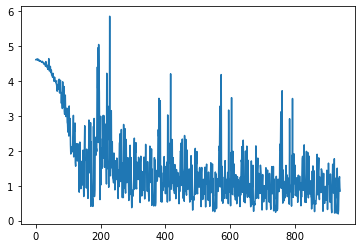

In [73]:
plt.plot(eval_loss_batch)
#plt.plot([188, 376, 564], eval_loss_epoch)
plt.show

9400
188.0
[188, 376, 564, 752, 940, 1128, 1316, 1504, 1692, 1880, 2068, 2256, 2444, 2632, 2820, 3008, 3196, 3384, 3572, 3760, 3948, 4136, 4324, 4512, 4700, 4888, 5076, 5264, 5452, 5640, 5828, 6016, 6204, 6392, 6580, 6768, 6956, 7144, 7332, 7520, 7708, 7896, 8084, 8272, 8460, 8648, 8836, 9024, 9212, 9400]


<function matplotlib.pyplot.show(close=None, block=None)>

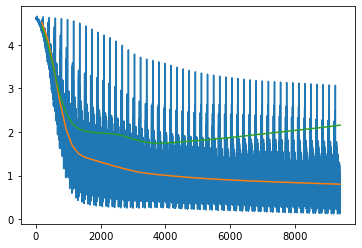

In [204]:
plt.plot(train_eval_loss_batch)
print(len(train_eval_loss_batch))
print(len(train_eval_loss_batch)/20)
batches = [i for i in range(188,9401,188)]
print(batches)
#plt.plot(batches, train_eval_loss_epoch)
#  plt.plot(batches, val_eval_loss_epoch)
plt.show

With adam optimizer, 50 epochs of training on the small dataset and 256 hidden_size and negative log likelyhood loss function the model heavily overfits.
Same goes for 128 hidden_size.
Same goes for cross entropy loss but not as heavily.
We need regularization!